<a href="https://colab.research.google.com/github/devansh2004/realtime-audio-sentiment/blob/main/Real_Time_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow tensorflow-io matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 7.3 MB/s eta 0:00:00


In [ ]:
!apt-get install -q portaudio19-dev

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libportaudio2 libportaudiocpp0
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 188 kB of archives.
After this operation, 927 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudiocpp0 amd64 19.6.0-1.1 [16.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 portaudio19-dev amd64 19.6.0-1.1 [106 kB]
Fetched 188 kB in 1s (265 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 123599 files and directories currently installed.)
Preparing to unpack .../libportaudio2_19.6.0-1.1_amd64.deb ...

In [ ]:
pip install pyaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyaudio: filename=PyAudio-0.2.14-cp310-cp310-linux_x86_64.whl size=63858 sha256=a4d128b28cb8edd53cc966e6faf0435cf2fd22b63327328fe6c311222a598b81
  Stored in directory: /root/.cache/pip/wheels/d6/21/f4/0b51d41ba79e51b16295cbb096ec49f334792814d545b508c5
Successfully built pyaudio


In [ ]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

In [ ]:
# location of wav files used for training
train_audio_loc = "/content/wav"

In [ ]:
# location of cvs file containing lables for the wav files
train_cvs_loc = "/content/"

In [ ]:
model_name = 'my_model'
model_loc = "/content/"

In [ ]:
# name of cvs file
CVS_name = "TRAIN.csv"

In [ ]:
df = pd.read_csv(os.path.join(train_cvs_loc,CVS_name))

In [ ]:
num_of_samples = len(df)

In [ ]:
# parameters on how to process the samples for the model
sample_parameters = {
    "frame_length" : 320,
    "frame_step" : 32,
    "sample_size" : 15000,
    "out_rate" : 8000

}

In [ ]:
batch_size = 1  #number of samples to train in each epoch
prefetch_size = 7 #number of samepls to preload while training to imporve latancy

In [ ]:
df['Class'] = df['Class'].map({'Negative': [1,0,0], 'Neutral': [0,1,0], 'Positive': [0,0,1]})

In [ ]:
df.head()

,Filename,Class
0,346.wav,"[1, 0, 0]"
1,163.wav,"[0, 1, 0]"
2,288.wav,"[1, 0, 0]"
3,279.wav,"[1, 0, 0]"
4,244.wav,"[1, 0, 0]"


In [ ]:
filenames = df["Filename"].values
labels = np.array(df['Class'].tolist())

In [ ]:
data = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(df["Filename"].values), tf.data.Dataset.from_tensor_slices(labels)))

In [ ]:
data = tf.data.Dataset.from_tensor_slices((filenames, labels))

In [ ]:
import soundfile
def format_wav_PCM_16(file_path, output_name):
  data, samplerate = soundfile.read(file_path)
  soundfile.write(output_name, data, samplerate, subtype='PCM_16')

In [ ]:
def load_wav_mono(filename, out_rate=8000):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=out_rate)
    return wav

In [ ]:
try:
  os.mkdir(os.path.join(train_audio_loc,"pcm_train"))
except FileExistsError:
  print("Folder already exists")


In [ ]:
dir = train_audio_loc
output_dir = os.path.join(train_audio_loc,"pcm_train")
for sample in os.listdir(dir):

  if(".wav" in sample):
    format_wav_PCM_16(os.path.join(dir,sample),os.path.join(output_dir, sample))

In [ ]:
train_audio_loc_processed = os.path.join(train_audio_loc,"pcm_train")

In [ ]:
dir = train_audio_loc_processed

lengths = []
for f in os.listdir(dir):
    tensor_wave = load_wav_mono(os.path.join(dir,f))
    lengths.append(len(tensor_wave))

In [ ]:
print(tf.math.reduce_mean(lengths))

tf.Tensor(21182, shape=(), dtype=int32)


In [ ]:
print(tf.math.reduce_min(lengths))

tf.Tensor(13583, shape=(), dtype=int32)


In [ ]:
print(tf.math.reduce_max(lengths))

tf.Tensor(31555, shape=(), dtype=int32)


In [ ]:
len(lengths)

250

In [ ]:
def preprocess(file_path, label, frame_length = 320, frame_step = 32, sample_size = 15000, out_rate = 8000):

  wav = load_wav_mono(file_path, out_rate)
  if(wav == None):
    raise Exception("File Does Not Exist")
  wav = wav[:sample_size]
  zero_padding = tf.zeros([sample_size] - tf.shape(wav), dtype=tf.float32)
  wav = tf.concat([zero_padding, wav],0)
  spectrogram = tf.signal.stft(wav, frame_length=frame_length, frame_step=frame_step)
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, axis=2)
  return spectrogram ,label

In [ ]:
dir = train_audio_loc_processed
x = data.as_numpy_iterator()
spectrograms_l = list()
labels_l = list()
while True:
    try:
        # Fetch the next batch
        samples, labels = x.next()
        sample_path = os.path.join(dir,samples.decode("utf-8"))
        spectrogram, label = preprocess(sample_path,labels, **sample_parameters)
        spectrograms_l.append(spectrogram)
        labels_l.append(label)
    except StopIteration:
        # Exit the loop when the iterator is exhausted
        break
data = tf.data.Dataset.from_tensor_slices((spectrograms_l, labels_l))

In [ ]:
s, l = data.as_numpy_iterator().next()
l

array([1, 0, 0])

In [ ]:
data_preprocessed = data
data_preprocessed = data_preprocessed.cache()
data_preprocessed = data_preprocessed.batch(batch_size)
data_preprocessed = data_preprocessed.prefetch(prefetch_size)

In [ ]:
data_preprocessed

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 459, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.int64, name=None))>

In [ ]:
import math
train_size = math.ceil((num_of_samples/batch_size)*0.8)
test_size = int((num_of_samples/batch_size) - train_size)
print(train_size)
print(test_size)

200
50


In [ ]:
train = data_preprocessed.take(train_size)
test = data_preprocessed.skip(train_size).take(test_size)

In [ ]:
samples, labels = test.as_numpy_iterator().next()
labels

array([[1, 0, 0]])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [ ]:
model = Sequential()
model.add(tf.keras.Input(shape=(459, 257,1)))
model.add(Conv2D(1, (3,3), activation='relu', padding='same'))
model.add(Conv2D(1, (3,3), activation='relu', padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 459, 257, 1)         │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 459, 257, 1)         │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 117963)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      15,099,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,099,799 (57.60 MB)

 Trainable params: 15,099,799 (57.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist = model.fit(train, epochs=2, validation_data=test)


Epoch 1/2
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 395ms/step - accuracy: 0.5579 - loss: 1.6092 - precision: 0.5766 - recall: 0.2497 - val_accuracy: 0.6200 - val_loss: 0.9319 - val_precision: 0.7037 - val_recall: 0.3800
Epoch 2/2
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 395ms/step - accuracy: 0.8404 - loss: 0.5747 - precision: 0.8710 - recall: 0.5733 - val_accuracy: 0.8200 - val_loss: 1.3696 - val_precision: 0.8250 - val_recall: 0.6600


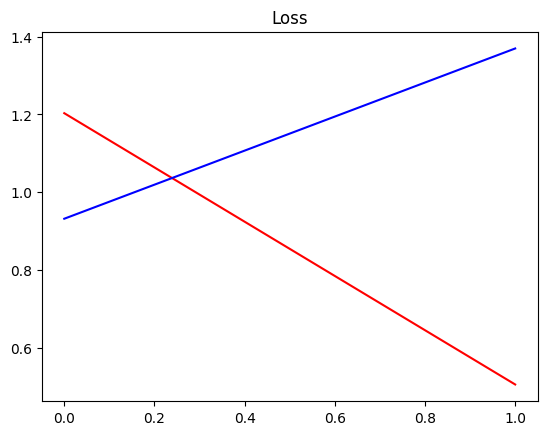

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()


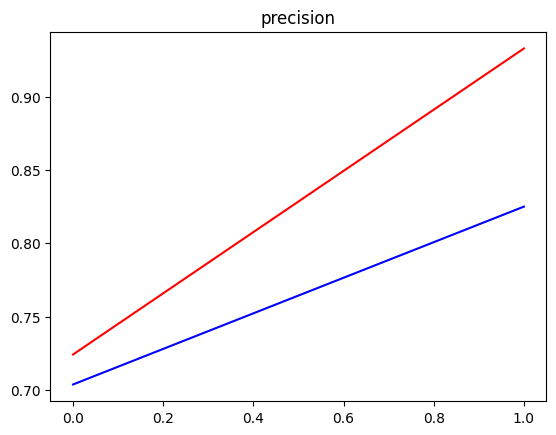

In [ ]:
plt.title('precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

In [ ]:
hist.history

{'accuracy': [0.6299999952316284, 0.8450000286102295],
 'loss': [1.2032346725463867, 0.5057351589202881],
 'precision': [0.7241379022598267, 0.9328358173370361],
 'recall': [0.3149999976158142, 0.625],
 'val_accuracy': [0.6200000047683716, 0.8199999928474426],
 'val_loss': [0.9318904280662537, 1.3696208000183105],
 'val_precision': [0.7037037014961243, 0.824999988079071],
 'val_recall': [0.3799999952316284, 0.6600000262260437]}

In [ ]:
def predict(filename, filepath, processed_filepath, output_label = False):

  try:
    format_wav_PCM_16(os.path.join(filepath,filename), os.path.join(processed_filepath, filename))
    s,l = preprocess(os.path.join(processed_filepath,filename),label)
  except:
    print("file does not exist")
    return

  prediction = model.predict(tf.expand_dims(s, axis=0))
  prediction = np.argmax(prediction)
  if(output_label):
    if(prediction == 0):
      return "Negative"
    elif(prediction == 1):
      return "Neutral"
    elif(prediction == 2):
      return "Positive"
  return prediction

In [ ]:
filename = "346.wav"

print(predict(filename,train_audio_loc, train_audio_loc_processed, output_label = True))
df[df['Filename'] == filename]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Negative


,Filename,Class
0,346.wav,"[1, 0, 0]"


In [ ]:
df[df['Class'].apply(lambda x: x == [1,0,0])]

,Filename,Class
0,346.wav,"[1, 0, 0]"
2,288.wav,"[1, 0, 0]"
3,279.wav,"[1, 0, 0]"
4,244.wav,"[1, 0, 0]"
5,273.wav,"[1, 0, 0]"
...,...,...
231,246.wav,"[1, 0, 0]"
233,286.wav,"[1, 0, 0]"
240,332.wav,"[1, 0, 0]"
243,278.wav,"[1, 0, 0]"


In [ ]:
y_pred = model.predict(test)

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step


In [ ]:
y_pred = [np.argmax(element) for element in y_pred]

In [ ]:
#y_pred

In [ ]:
batches = [element for element in test.as_numpy_iterator()]
y_test = [np.argmax(batch[1]) for batch in batches]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))

[[12  0  5]
 [ 0 14  1]
 [ 2  1 15]]
              precision    recall  f1-score   support

           0       0.86      0.71      0.77        17
           1       0.93      0.93      0.93        15
           2       0.71      0.83      0.77        18

    accuracy                           0.82        50
   macro avg       0.83      0.82      0.83        50
weighted avg       0.83      0.82      0.82        50



In [ ]:
model.save(os.path.join(model_loc,model_name + '.keras'))

In [ ]:
import pyaudio
import numpy as np

FRAMES_PER_BUFFER = 3200
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
p = pyaudio.PyAudio()

def record_audio():
    stream = p.open(
        format=FORMAT,
        channels=CHANNELS,
        rate=RATE,
        input=True,
        frames_per_buffer=FRAMES_PER_BUFFER
    )

    #print("start recording...")

    frames = []
    seconds = 1
    for i in range(0, int(RATE / FRAMES_PER_BUFFER * seconds)):
        data = stream.read(FRAMES_PER_BUFFER)
        frames.append(data)

    # print("recording stopped")

    stream.stop_stream()
    stream.close()

    return np.frombuffer(b''.join(frames), dtype=np.int16)


def terminate():
    p.terminate()

In [ ]:
def get_spectrogram(waveform, frame_length = 320, frame_step = 32, sample_size = 15000, out_rate = 8000):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    wav = wav[:sample_size]
    zero_padding = tf.zeros([sample_size] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=frame_length, frame_step=frame_step)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram




def preprocess_audiobuffer(waveform, frame_length = 320, frame_step = 32, sample_size = 15000, out_rate = 8000):
    """
    waveform: ndarray of size (16000, )

    output: Spectogram Tensor of size: (1, `height`, `width`, `channels`)
    """
    #  normalize from [-32768, 32767] to [-1, 1]
    waveform =  waveform / 32768

    waveform = tf.convert_to_tensor(waveform, dtype=tf.float32)

    waveform = tfio.audio.resample(wawaveformv, rate_in=RATE, rate_out=out_rate)

    waveform = tf.convert_to_tensor(waveform, dtype=tf.float32)

    spectogram = get_spectrogram(waveform)

    # add one dimension
    spectogram = tf.expand_dims(spectogram, 0)

    return spectogram

In [ ]:
from tensorflow.keras import models


loaded_model = models.load_model(os.path.join(model_loc,model_name + '.keras'))

def predict_mic():
    audio = record_audio()
    spec = preprocess_audiobuffer(audio, **sample_parameters)
    prediction = loaded_model(spec)
    label_pred = np.argmax(prediction, axis=1)
    sentiment = label_pred[0]
    if sentiment == 0:
        sentiment = "Negative"
    elif sentiment == 1:
        sentiment = "Neutral"
    elif sentiment == 2:
        sentiment = "Positive"
    print("Predicted label:", sentiment)
    return sentiment

if __name__ == "__main__":
    while True:
      sentiment = predict_mic()